## Comparing sweights vs MLE

Compare sWeights and MLE on the same data.

In [2]:
#import essential packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

#defining the pdfs 
from scipy.stats import crystalball, norm

#for finding maximum of total pdf, curve fit
from scipy.optimize import minimize, curve_fit

#EML fit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

#sWeights package
from sweights import SWeight

#timing how long functions take
import timeit

#show the loading bar
from tqdm import tqdm

#plotting uncertainties
from uncertainties import ufloat

In [3]:
#define the functions using scipy stats 
#commented out scipy stats functions because they are slower
#defined equations instead

#signal for X
def g_s(X, beta, m, mu, sigma):
    return crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma))

# def h_s(Y, lmbda):
#     trunc_b = (10.0 - 0.0)*lmbda
#     return truncexpon.pdf(Y, trunc_b, 0.0, 1/lmbda)


#signal for Y
def h_s(Y, lmbda):
    pdf = lmbda * np.exp(-lmbda * Y)
    norm_factor = 1 - np.exp(-10 * lmbda)
    return pdf / norm_factor

# def g_b(X):
#     return uniform.pdf(X, 0.0, 5.0)

#background for X
def g_b(X):
    if isinstance(X, (float, int)): #scalar input
        return 1/5.0 if 0 <= X <= 5 else 0
    else:  # numpy array input
        return np.where((X >= 0) & (X <= 5), 1/5.0, 0)

# def h_b(Y, mu_b, sigma_b):
#     a = (mu_b - 0.0)/sigma_b
#     b = (10.0 - mu_b)/sigma_b
#     return truncnorm.pdf(Y, a, b, mu_b, sigma_b)

#background for Y
def h_b(Y, mu_b, sigma_b):
    pdf = (1/(sigma_b * np.sqrt(2*np.pi))) * np.exp(-(Y - mu_b)**2 / (2*sigma_b**2))
    norm_factor = norm.cdf(10, mu_b, sigma_b) - norm.cdf(0, mu_b, sigma_b)
    return pdf / norm_factor

#marginal distribution in X
def marg_X(X, f, mu, sigma, beta, m):
    return f*g_s(X, beta, m, mu, sigma) + (1-f)*g_b(X)

#marginal distribution in Y
def marg_Y(Y, f, lmbda, mu_b, sigma_b):
    return f*h_s (Y, lmbda) + (1-f)*h_b(Y, mu_b, sigma_b)

#total signal distribution
def signal(X, Y, mu, sigma, beta, m, f, lmbda):
    return f * g_s(X, beta, m, mu, sigma) * h_s(Y, lmbda)

#total background distribution 
def background(X, Y, f, mu_b, sigma_b):
    return (1-f) * g_b(X) * h_b(Y, mu_b, sigma_b)

#total joint distribution
def total(X, Y, mu, sigma, beta, m, f, lmbda, mu_b, sigma_b):
    return signal(X, Y, mu, sigma, beta, m, f, lmbda) + background(X, Y, f, mu_b, sigma_b)


In [4]:
#Create find max of this 2d function
def find_fmax_2d(func, x_range = (0.0, 5.0), y_range = (0.0, 10.0)):
    f_to_min = lambda vars: -func(vars[0], vars[1])
    initial_guess = [0,1]
    result = minimize(f_to_min, x0 = initial_guess, bounds = [x_range, y_range])
    max_x, max_y = result.x
    max_f = func(max_x, max_y)
    return max_f

#quicker accept reject sampler
def accept_reject_2d(func, x_range = [0, 5], y_range = [0, 10], num_samples=50, seed=1, batch_size=1000):

    np.random.seed(seed)
    
    x_samples = []
    y_samples = []

    f_max = find_fmax_2d(func)
    
    while len(x_samples) < num_samples:
        # Generate a batch of random samples
        x_temp = np.random.uniform(x_range[0], x_range[1], batch_size)
        y_temp = np.random.uniform(y_range[0], y_range[1], batch_size)
        f_temp = np.random.uniform(0, f_max, batch_size)
        
        # Evaluate the function for the batch
        f_values = func(x_temp, y_temp)
        
        # Apply the acceptance criterion
        accepted = f_temp < f_values
        
        # Append accepted samples
        x_samples.extend(x_temp[accepted])
        y_samples.extend(y_temp[accepted])
    
    # Convert lists to arrays and trim to the desired number of samples
    x_samples = np.array(x_samples[:num_samples])
    y_samples = np.array(y_samples[:num_samples])
    
    return x_samples, y_samples

In [5]:
#Parametric bootstrapping
#ensembles of 250 samples. Each sample has size 500, 1000, 2500, 5000, 10000

N_sample = [500, 1000, 2500, 5000, 10000] #number of samples per toy
param_names = ['N', '\mu', '\sigma', '\\beta', 'm', 'f', '\lambda', '\mu_b', '\sigma_b']
true_values = [3, 0.3, 1, 1.4, 0.6, 0.3, 0, 2.5]#except N which differs
fitted_values = np.loadtxt('data_storage/fitted_values.csv', delimiter=',')
fitted_values = fitted_values[1:] #get rid of the N value because we will change this for each bootstrap

#create new joint distribution with fitted parameters instead
def total_fixed_fitted(X, Y):
    return total(
        X, Y, 
        mu=fitted_values[0], sigma=fitted_values[1], beta=fitted_values[2], m=fitted_values[3], 
        f=fitted_values[4], lmbda=fitted_values[5], mu_b=fitted_values[6], sigma_b=fitted_values[7]
    )

def model_density(data, N, mu, sigma, beta, m, f, lmbda, mu_b, sigma_b):

    X, Y = data

    g_s = crystalball.pdf(X, beta, m, mu, sigma) / max((crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma)), 1e-10)

    pdf = lmbda * np.exp(-lmbda * Y)
    norm_factor = 1 - np.exp(-10 * lmbda)
    h_s = pdf/norm_factor

    g_b = np.where((X >= 0) & (X <= 5), 1/5.0, 0)

    pdf0 = (1/(sigma_b * np.sqrt(2*np.pi))) * np.exp(-(Y - mu_b)**2 / (2*sigma_b**2))
    norm_factor0 = norm.cdf(10, mu_b, sigma_b) - norm.cdf(0, mu_b, sigma_b)
    h_b = pdf0/norm_factor0

    signal = f * g_s * h_s
    background = (1-f) * g_b * h_b

    total = signal + background

    return N, N*total

#Make a bootstrap of size N
def generate_bootstrap (N, seed = 1):
    N = np.random.poisson(N)
    x_samples, y_samples = accept_reject_2d(total_fixed_fitted, num_samples=N, seed = seed)
    
    return x_samples, y_samples

#make an ensemble of these bootstrapped value 
def generate_ensemble(N_sample, N_ensemble = 250):
    toys = [generate_bootstrap(N_sample, seed= i) for i in tqdm(range(N_ensemble))]
    return toys 

#fit a sample using the fitted values 
def fit_model(data, N_sample):
    X, Y = data
    nll = ExtendedUnbinnedNLL((X,Y), model_density)
    #starting params
    mi = Minuit(nll, 
            N=N_sample,
            mu=fitted_values[0], 
            sigma=fitted_values[1], 
            beta=fitted_values[2], 
            m=fitted_values[3], 
            f=fitted_values[4], 
            lmbda=fitted_values[5], 
            mu_b=fitted_values[6], 
            sigma_b=fitted_values[7])
    #limits
    mi.limits["N"] = (0, None)
    mi.limits["beta"] = (0, 10)
    mi.limits["m"] = (1, 10)
    mi.limits['sigma'] = (0,None)
    mi.limits['sigma_b'] = (0, None)

    mi.migrad()
    mi.hesse()

    return mi

In [42]:
#sweights code

#New model density for X
def X_model_density(X, Ns, Nb, mu, sigma, beta, m):

    #define pdfs again here, because it is quicker for the minimiser
    g_s = crystalball.pdf(X, beta, m, mu, sigma) / max((crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma)), 1e-10) #just in case it gets so small

    #g_b = uniform.pdf(X, 0.0, 5.0)
    g_b = np.where((X >= 0) & (X <= 5), 1/5.0, 0)

    signal = Ns * g_s
    background = Nb * g_b

    total = signal + background

    return Ns+Nb, total

def fit_X_model_density (data, N_sample):

    X, Y = data
    #fit the X data
    nll = ExtendedUnbinnedNLL(X, X_model_density)

    mi = Minuit(nll, 
                Ns = N_sample * fitted_values[4],
                Nb = N_sample * (1-fitted_values[4]),
                mu=fitted_values[0],
                sigma=fitted_values[1],
                beta=fitted_values[2],
                m=fitted_values[3]
)

    #input limits
    mi.limits["Ns"] = (0, None)
    mi.limits["Nb"] = (0, None)
    mi.limits["beta"] = (0, 10)
    mi.limits["m"] = (1, 10)
    mi.limits["sigma"] = (0, 10)

    mi.migrad()
    mi.hesse()

    return mi

def get_sweights (data, mi):
    
    X, Y = data
    #define pdfs to put into sWeights
    spdf = lambda x: g_s(x, mi.values['beta'], mi.values['m'], mi.values['mu'], mi.values['sigma'])
    bpdf = lambda x: g_b(x)
    sweight = SWeight(X, [spdf, bpdf], yields = [mi.values['Ns'], mi.values['Nb']], discvarranges=([0,5],), verbose = False, checks = False)
    
    sw = sweight.get_weight(0, X)
    #bw = sweight.get_weight(1, X)
    ysw, ye = np.histogram(Y, bins = 50, range = [0,10], weights = sw, density = False)
    bin_width = ye[1]-ye[0] #constant bin width here
    cy = 0.5 * (ye[1:] + ye[:-1]) 

    popt, pcov = curve_fit(lambda y, lmbda: h_s(y, lmbda) * mi.values['Ns'] * bin_width, cy, ysw, fitted_values[5])
    lmbda_sw = popt[0]
    lmbda_sw_error = np.sqrt(pcov[0][0])
    lmbda_sw_pulls = (lmbda_sw - fitted_values[5])/lmbda_sw_error


    return lmbda_sw, lmbda_sw_error, lmbda_sw_pulls

In [7]:
def bootstrap(N_sample, N_ensemble = 250):
    #generate toys 
    toys = generate_ensemble(N_sample, N_ensemble = N_ensemble)
    print('Finished generating samples')
    values = []
    errors = []
    invalid_fits = 0
    invalid_fits_sw = 0
    values_sw = []
    errors_sw = []
    pulls_sw = []
    print('Fitting samples.')

    #fit all of the toys
    for toy in tqdm(toys):
        #MLE fit of params
        mi = fit_model(toy, N_sample)
        if mi.valid:
            values.append(list(mi.values))
            errors.append(list(mi.errors))
        else:
            invalid_fits += 1
        #sweight fit of lmbda 
        mi_X = fit_X_model_density(toy, N_sample)
        if mi_X.valid:
            value_sw, error_sw, pull_sw = get_sweights(toy, mi_X)
            values_sw.append(value_sw)
            errors_sw.append(error_sw)
            pulls_sw.append(pull_sw)
        else:
            invalid_fits_sw += 1
        
        #print(len(mi.values))

    #get the values, errors and pulls
    values = np.array(values)
    #print(len(values[0]))
    errors = np.array(errors)
    #print(errors)
    fitted_values_t = np.concatenate((np.array([N_sample]), fitted_values))
    #print(len(fitted_values_t))
    pulls = (values - fitted_values_t)/errors

    #save MLE fits
    np.savetxt(f'data_storage/bootstraps/bootstrap_{N_sample}.csv', 
           np.column_stack((values, errors, pulls)), 
           delimiter=',',
           header='values, errors, pulls')
    
    np.savetxt(f'data_storage/bootstraps_sweights2/bootstrap_{N_sample}.csv', 
           np.column_stack((values_sw, errors_sw, pulls_sw)), 
           delimiter=',',
           header='values, errors, pulls')
    
    print(f'Invalid fits for MLE are {invalid_fits} out of {N_ensemble} toys')
    print(f'Invalid fits for sWeights are {invalid_fits_sw} out of {N_ensemble} toys')

    return None

In [43]:
#if you only want to calculate sweights
#the samples will be the same because we set a random seed

def bootstrap_sw(N_sample, N_ensemble = 250):
    #generate toys 
    toys = generate_ensemble(N_sample, N_ensemble = N_ensemble)
    print('Finished generating samples')
    values = []
    errors = []
    pulls = []
    invalid_fits_sw = 0
    print('Fitting samples.')

    #fit all of the toys
    for toy in tqdm(toys):
        #sweight fit of lmbda 
        mi_X = fit_X_model_density(toy, N_sample)
        if mi_X.valid:
            values_sw, errors_sw, pulls_sw = get_sweights(toy, mi_X)
            values.append(values_sw)
            errors.append(errors_sw)
            pulls.append(pulls_sw)
        else:
            invalid_fits_sw += 1

    
    np.savetxt(f'data_storage/bootstraps_sweights2/bootstrap_{N_sample}.csv', 
           np.column_stack((values, errors, pulls)), 
           delimiter=',',
           header='values, errors, pulls')
    
    print(f'Invalid fits for sWeights are {invalid_fits_sw} out of {N_ensemble} toys')

    return None

In [40]:
N_samples = [500, 1000, 2500, 5000, 10000]

In [46]:
for N_sample in N_samples:
    bootstrap_sw(N_sample, 500)

100%|██████████| 500/500 [00:14<00:00, 35.57it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [05:17<00:00,  1.57it/s]


Invalid fits for sWeights are 1 out of 500 toys


100%|██████████| 500/500 [00:28<00:00, 17.62it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [02:47<00:00,  2.99it/s]


Invalid fits for sWeights are 1 out of 500 toys


100%|██████████| 500/500 [00:25<00:00, 19.58it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [03:35<00:00,  2.32it/s]


Invalid fits for sWeights are 0 out of 500 toys


100%|██████████| 500/500 [00:37<00:00, 13.22it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


Invalid fits for sWeights are 2 out of 500 toys


100%|██████████| 500/500 [01:13<00:00,  6.81it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [09:13<00:00,  1.11s/it]

Invalid fits for sWeights are 0 out of 500 toys


In [47]:
#Load all the saved data
data_500 = np.loadtxt(f'data_storage/bootstraps_sweights2/bootstrap_500.csv', delimiter=',',skiprows=1)
data_1000 = np.loadtxt(f'data_storage/bootstraps_sweights2/bootstrap_1000.csv', delimiter=',',skiprows=1)
data_2500 = np.loadtxt(f'data_storage/bootstraps_sweights2/bootstrap_2500.csv', delimiter=',',skiprows=1)
data_5000 = np.loadtxt(f'data_storage/bootstraps_sweights2/bootstrap_5000.csv', delimiter=',',skiprows=1)
data_10000 = np.loadtxt(f'data_storage/bootstraps_sweights2/bootstrap_10000.csv', delimiter=',',skiprows=1)

data_list = [data_500, data_1000, data_2500, data_5000, data_10000]


In [54]:
N_sample = [500, 1000, 2500, 5000, 10000]
def plot(vals, ax=None, param_name=None, plot_param=False, plot_var=False):
    ax = ax or plt.gca()
    
    # Only apply parameter constraints for parameter value plots, not for variance
    if plot_param:
        if param_name == 'm':
            vals = vals[vals > 1]
        elif param_name == 'beta':
            vals = vals[vals > 0]
    elif plot_var:
        vals = vals[vals >= 0]  # Only ensure variances are non-negative
    
    # Check if we have enough data points
    if len(vals) <= 1:
        print(f"Warning: Not enough data points for {param_name} (n={len(vals)})")
        return
    
    # Remove outliers (5%)
    lower_percentile = np.percentile(vals, 2.5)
    upper_percentile = np.percentile(vals, 97.5)
    filtered_vals = vals[(vals >= lower_percentile) & (vals <= upper_percentile)]
    
    # Compute statistics using filtered values
    mean = np.mean(filtered_vals)
    std = np.std(filtered_vals, ddof=1) #bessel correction

    # if std < 1e-10:  # If standard deviation is very small
    #     std = max(std, mean * 1e-3)
    mean_err = std / len(filtered_vals)**0.5
    std_err = std/(2*len(filtered_vals)-1)**0.5 
    
    # Handle std calculation carefully
    if len(filtered_vals) > 1:
        std = np.std(filtered_vals, ddof=1)
    else:
        std = 0.1 * mean  # Use a reasonable default
        print(f"Warning: Using default std for {param_name}")
    
    if plot_var:
        plot_range = (max(0, mean - 3*std), mean + 3*std)
    elif plot_param:
        if param_name == 'm':
            plot_range = (max(mean - 3*std, 1), mean + 3*std)
        elif param_name == 'beta':
            plot_range = (max(mean - 3*std, 0), mean + 3*std)
        else:
            plot_range = (mean - 3*std, mean + 3*std)
    else:
        plot_range = (mean - 3*std, mean + 3*std)

    # Density histograms
    nh, xe = np.histogram(filtered_vals, range=plot_range, bins='auto', density=True)
    ax.hist(filtered_vals, bins=xe, density=True, alpha=0.5)
    
    # Error bars
    sf = np.sum(nh)/len(filtered_vals)
    cx = 0.5 * (xe[1:]+xe[:-1])
    ax.errorbar(cx, nh, sf*(nh/sf)**0.5, fmt='ko')
    
    # Draw normal distribution only over valid range
    x = np.linspace(plot_range[0], plot_range[1], 100)
    ax.plot(x, norm.pdf(x, mean, std), 'r-')
    
    # Plot results
    mean_u = ufloat(mean, mean_err)
    std_u = ufloat(std, std_err)
    mstr = f'{mean_u:.1u}'.replace('+/-', '\pm')
    sstr = f'{std_u:.1u}'.replace('+/-', '\pm')
    ax.text(0.01, 0.92, f'$\hat{{\mu}}= {mstr}$', transform=ax.transAxes)
    ax.text(0.01, 0.86, f'$\hat{{\sigma}} = {sstr}$', transform=ax.transAxes)

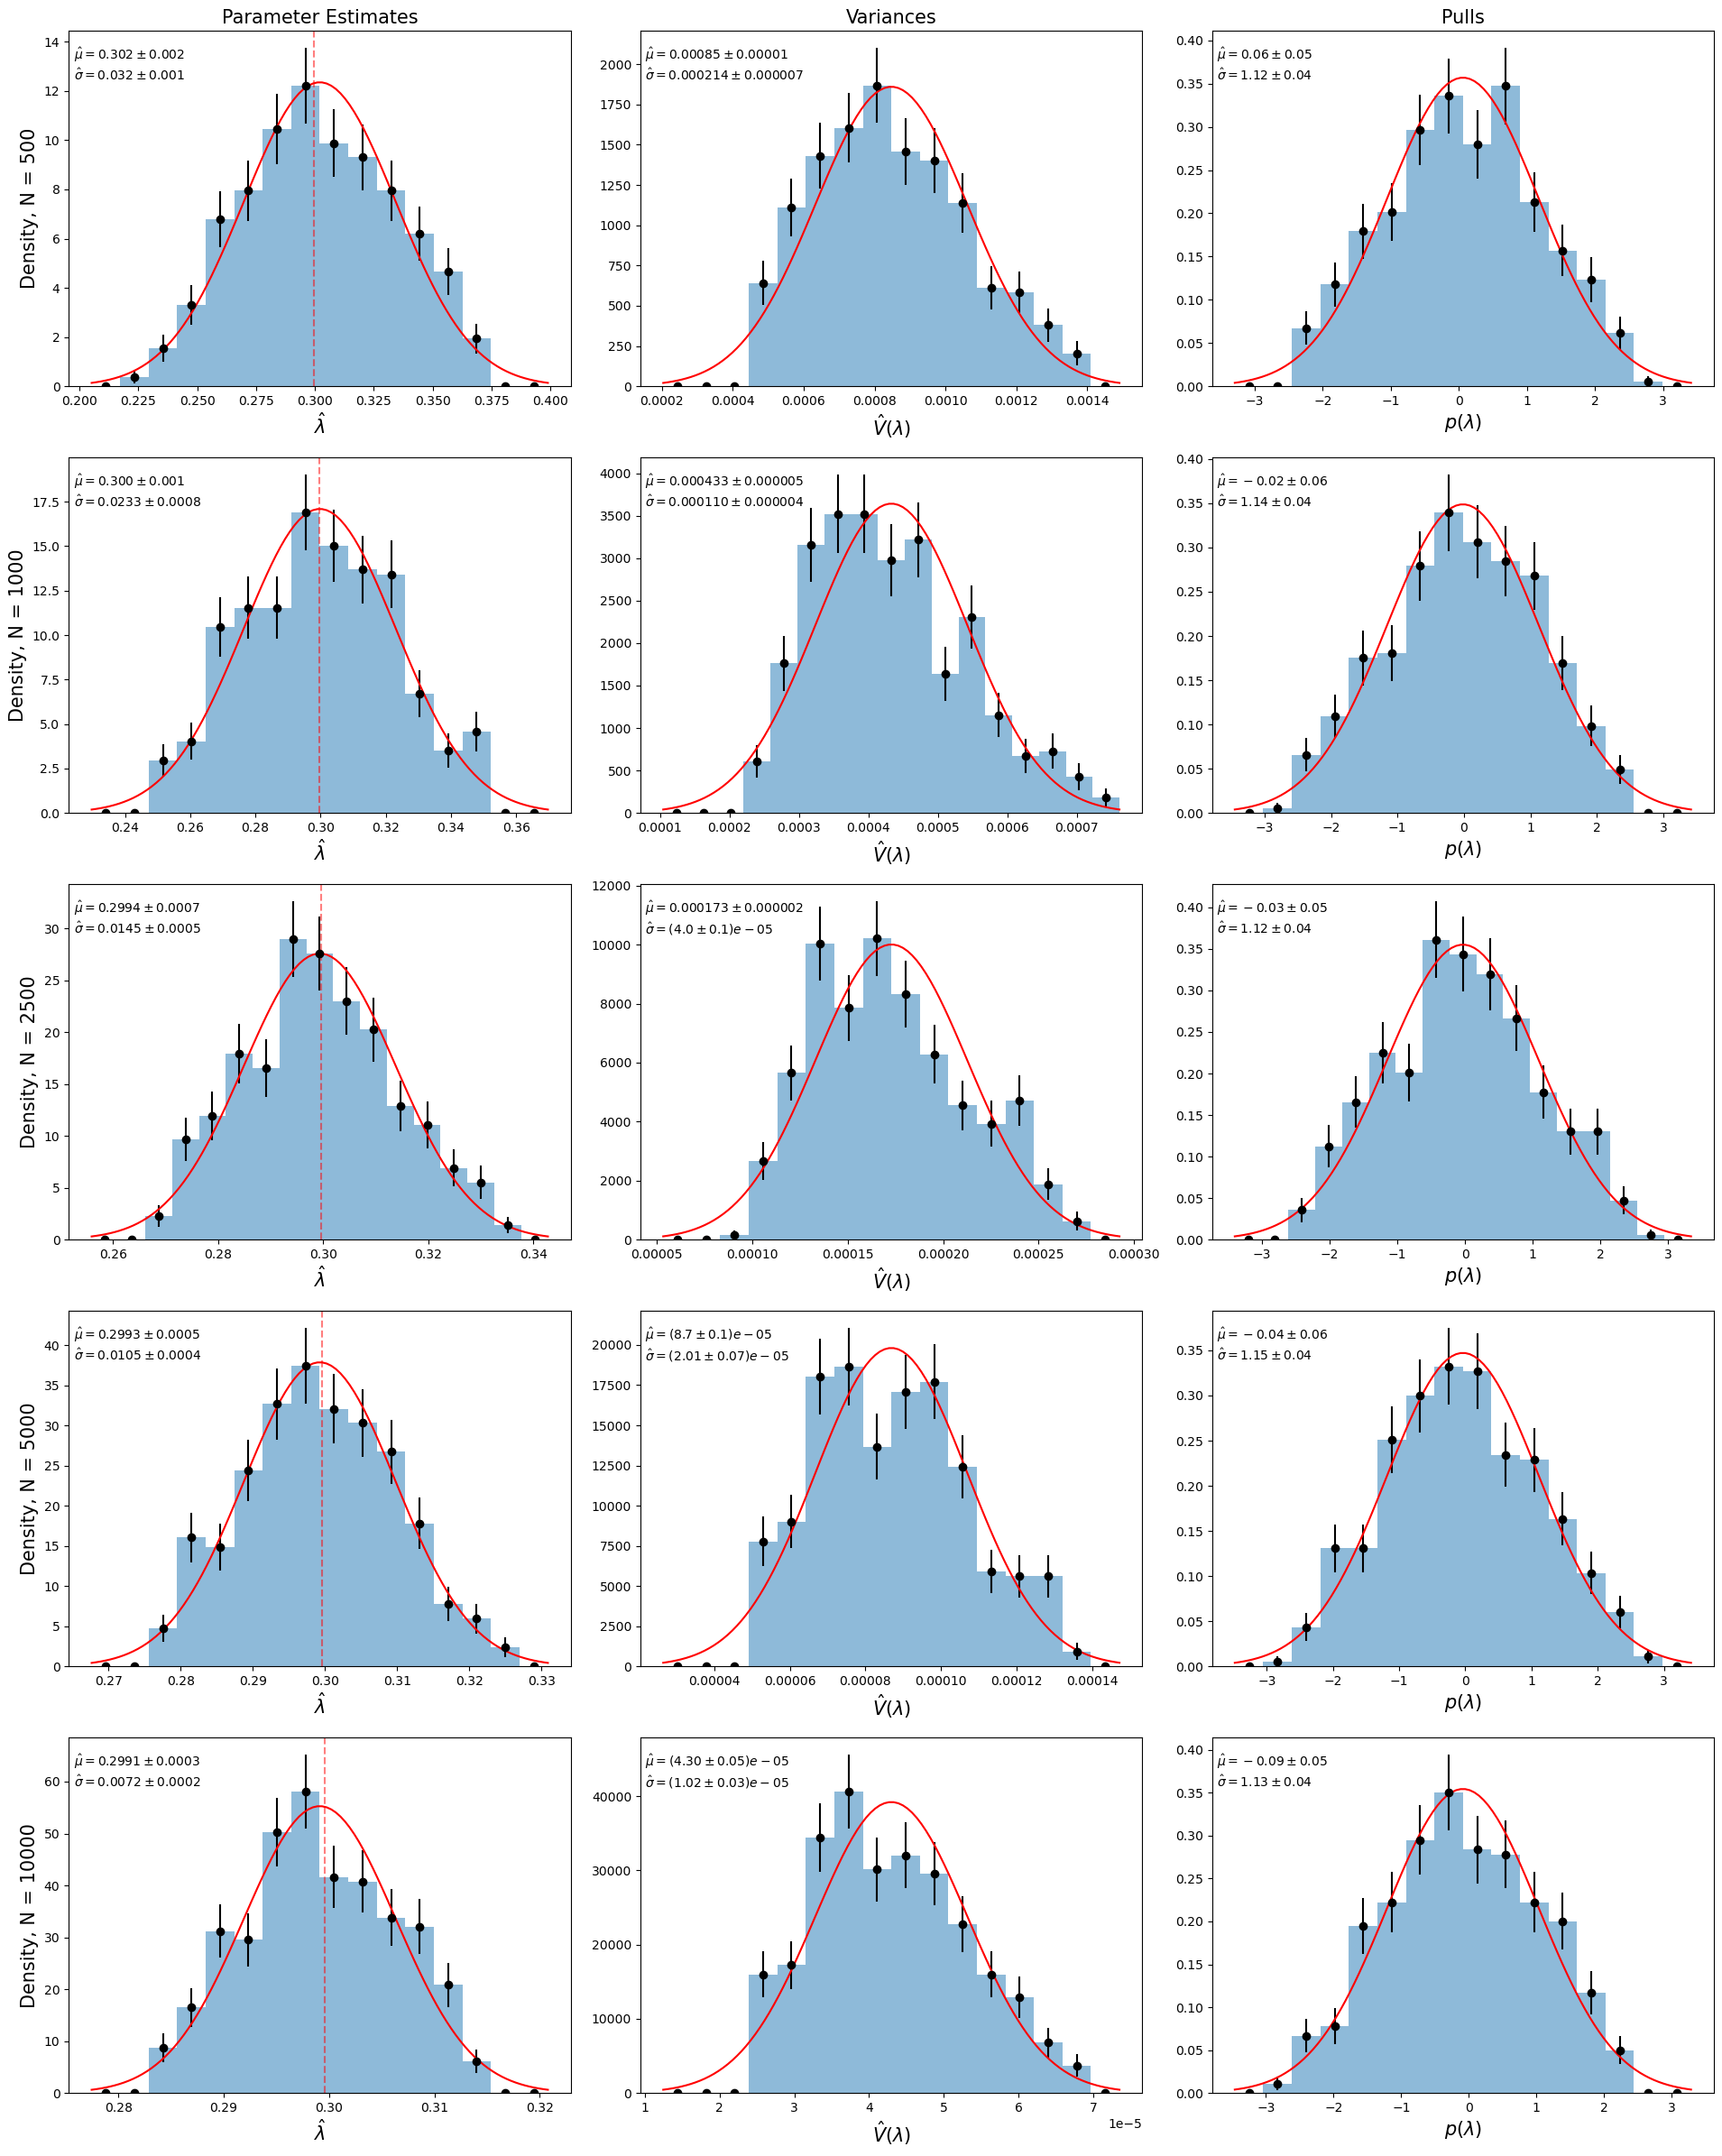

(<Figure size 1920x2400 with 15 Axes>,
 array([[<Axes: title={'center': 'Parameter Estimates'}, xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 500'>,
         <Axes: title={'center': 'Variances'}, xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: title={'center': 'Pulls'}, xlabel='$p(\\lambda)$'>],
        [<Axes: xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 1000'>,
         <Axes: xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: xlabel='$p(\\lambda)$'>],
        [<Axes: xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 2500'>,
         <Axes: xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: xlabel='$p(\\lambda)$'>],
        [<Axes: xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 5000'>,
         <Axes: xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: xlabel='$p(\\lambda)$'>],
        [<Axes: xlabel='$\\hat{\\lambda}$', ylabel='Density, N = 10000'>,
         <Axes: xlabel='$\\hat{{V}}(\\lambda)$'>,
         <Axes: xlabel='$p(\\lambda)$'>]], dtype=object))

In [87]:
fontsize = 15

def load_data_sw(data, cut_val=450):

    n_params = 1
    # Reshape data to ensure it's 2D even with single parameter
    values = data[:, :n_params]
    errors = data[:, n_params:2*n_params]
    pulls = data[:, 2*n_params:3*n_params]
    return values[:cut_val], errors[:cut_val], pulls[:cut_val]

def plot_lambda_comparison_all(N_samples, all_values, all_errors, all_pulls, param_names):

    # Find lambda index in param_names
    lambda_idx = param_names.index('\\lambda')
    
    # Create figure with 5x3 subplots (one row per N)
    fig, axes = plt.subplots(len(N_samples), 3, figsize=(19.2, 24))
    
    # Format parameter name for LaTeX
    base_name = 'lambda'
    
    for i, (N, values, errors, pulls) in enumerate(zip(N_samples, all_values, all_errors, all_pulls)):
        fitted_values_t = np.concatenate((np.array([N]), fitted_values))
        
        # Parameter values plot
        ax = axes[i, 0]
        plot(values.flatten(), ax, param_name=base_name, plot_param=True)  # Changed this line
        ax.set_xlabel(r"$\hat{\lambda}$", fontsize = fontsize)
        ax.axvline(fitted_values_t[lambda_idx], color='r', linestyle='--', alpha=0.5)
        
        # Variance plot (errors squared)
        ax = axes[i, 1]
        plot(errors.flatten()**2, ax, param_name=base_name, plot_var=True)  # Changed this line
        ax.set_xlabel(r"$\hat{{V}}(\lambda)$", fontsize = fontsize)
        
        # Pulls plot
        ax = axes[i, 2]
        plot(pulls.flatten(), ax, param_name=base_name)  # Changed this line
        ax.set_xlabel(r"$p(\lambda)$", fontsize = fontsize)
        
        # Add row label
        axes[i, 0].set_ylabel(f"Density, N = {N}", fontsize = fontsize)
    
    # Add column headers
    axes[0, 0].set_title("Parameter Estimates", fontsize = fontsize)
    axes[0, 1].set_title("Variances", fontsize = fontsize)
    axes[0, 2].set_title("Pulls", fontsize = fontsize)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'data_storage/bootstraps/lambda_plots/lambda_comparison_sw.png')
    plt.show()
    
    return fig, axes

# Usage:
all_values = []
all_errors = []
all_pulls = []

for i in range(len(N_sample)):
    values, errors, pulls = load_data_sw(data_list[i], cut_val=450)
    all_values.append(values)
    all_errors.append(errors)
    all_pulls.append(pulls)

plot_lambda_comparison_all(N_sample, all_values, all_errors, all_pulls, param_names)

In [12]:
lmbdas_sw_500 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_500.csv')
lmbdas_sw_1000 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_1000.csv')
lmbdas_sw_2500 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_2500.csv')
lmbdas_sw_5000 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_5000.csv')
lmbdas_sw_10000 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_10000.csv')

data_list_sw = [lmbdas_sw_500, lmbdas_sw_1000, lmbdas_sw_2500, lmbdas_sw_5000, lmbdas_sw_10000]
data_list_sw = [lmbda[:450] for lmbda in data_list_sw] #cut to all the same length

In [74]:
#Get the average and std of the lambdas 
def get_lmbdas_mean(data_list):
    lmbdas_mean = []
    lmbdas_std = []
    for data in data_list:
        values, _, _ = load_data_sw(data)
        lmbda_vals = values
        print(len(lmbda_vals)) #check that they have the expected length
        lmbdas_mean.append(np.mean(lmbda_vals))
        lmbdas_std.append(np.std(lmbda_vals, ddof=1)/(np.sqrt(450)))
    return lmbdas_mean, lmbdas_std
lmbdas_mean, lmbdas_std = np.array(get_lmbdas_mean(data_list))
#find the bias
lmbdas_bias = lmbdas_mean - fitted_values[5]

450
450
450
450
450


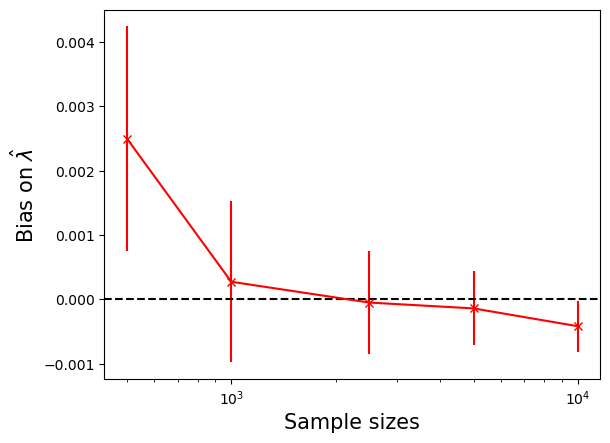

In [88]:
plt.errorbar(N_samples, lmbdas_bias, yerr = lmbdas_std, fmt = 'rx', ls = '-')
#plt.plot(N_samples, lmbdas_bias_sw, 'o', ls = '-')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'Bias on $\hat{\lambda}$', fontsize = fontsize)
plt.xlabel('Sample sizes', fontsize = fontsize)
plt.axhline(y=0, color = 'black', ls = '--')
plt.savefig('data_storage/bootstraps/lambda_plots/SW_bias.png', bbox_inches = 'tight')

0.0020524163538635106


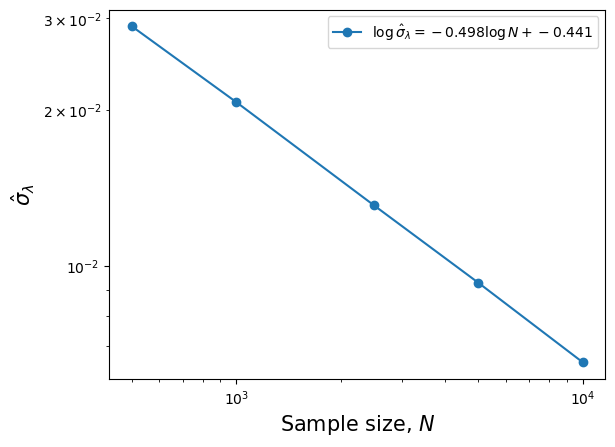

In [90]:
def get_lmbdas_var(data_list):
    lmbdas_var = []
    lmbdas_var_std = []
    for data in data_list:
        _, errors, _ = load_data_sw(data)
        var = errors #this is actually the std 
        lmbdas_var.append(np.mean(var))
        lmbdas_var_std.append(np.std(var, ddof=1)/(np.sqrt(450)))
    return lmbdas_var, lmbdas_var_std
lmbdas_var, lmbdas_var_std = np.array(get_lmbdas_var(data_list))

#Log-log plot should show linear line

log_var = np.log(lmbdas_var)
log_N = np.log(N_sample)
coeffs, cov = np.polyfit(log_N, log_var, 1, cov = True)

plt.plot(N_sample, lmbdas_var, 'o',ls = '-', label = rf'$\log{{\hat{{\sigma}}_{{\lambda}}}} = {coeffs[0]:.3f}\log{{N}} + {coeffs[1]:.3f}$')

#plt.errorbar(N_sample, lmbdas_var, yerr = lmbdas_var_std) #error bars so small you cannot see them
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Sample size, $N$', fontsize = fontsize)
plt.ylabel(r'$\hat{\sigma}_{{{{\lambda}}}}$', fontsize = fontsize)
plt.legend()
plt.savefig('data_storage/bootstraps/lambda_plots/var_lambda_sweights.png', bbox_inches = 'tight')

print(np.sqrt(cov[0][0]))

Plot bias and variance for MLE and sWeights on the same plot

In [78]:
bias_mle, bias_mle_errors =  np.loadtxt('data_storage/bootstraps/lambda_plots/MLE_bias.csv', delimiter=',')
var_mle = np.loadtxt('data_storage/bootstraps/lambda_plots/MLE_var.csv', delimiter=',')

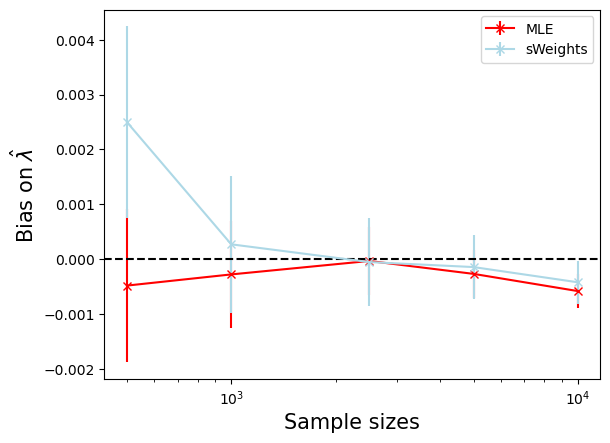

In [91]:
plt.errorbar(N_samples, bias_mle, yerr = bias_mle_errors, fmt = 'x', ls = '-', color = 'red', label = 'MLE')
plt.errorbar(N_samples, lmbdas_bias, yerr = lmbdas_std, fmt = 'x', ls = '-', color = 'lightblue', label = 'sWeights')
#plt.plot(N_samples, lmbdas_bias_sw, 'o', ls = '-')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'Bias on $\hat{\lambda}$', fontsize = fontsize)
plt.xlabel('Sample sizes', fontsize = fontsize)
plt.axhline(y=0, color = 'black', ls = '--')
plt.legend()
plt.savefig('data_storage/bootstraps/lambda_plots/bias.png', bbox_inches = 'tight')

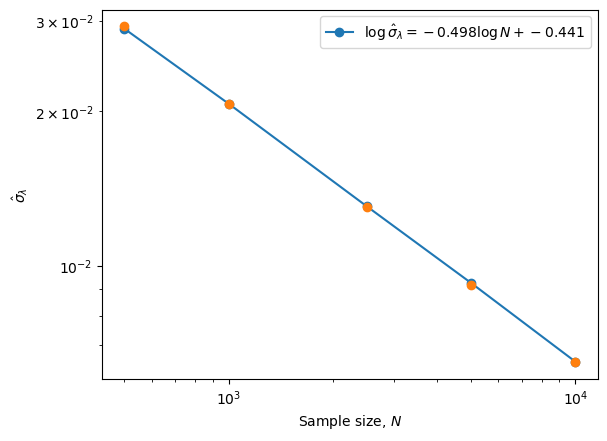

In [86]:
plt.plot(N_sample, lmbdas_var, 'o',ls = '-', label = rf'$\log{{\hat{{\sigma}}_{{\lambda}}}} = {coeffs[0]:.3f}\log{{N}} + {coeffs[1]:.3f}$')
plt.plot(N_sample, var_mle, 'o')

#plt.errorbar(N_sample, lmbdas_var, yerr = lmbdas_var_std) #error bars so small you cannot see them
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Sample size, $N$')
plt.ylabel(r'$\hat{\sigma}_{{{{\lambda}}}}$')
plt.legend()
#plt.savefig('data_storage/bootstraps/lambda_plots/var_lambda_sweights.png')

#these look the same.... i shant include them on the report... hehehehe